In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>
<br>
<br>

# **Treinamento do Modelo (Modelo Performático usando o Optuna)**

Neste notebook vamos treinar o modelo usando outros algoritmos de machine learning, afim de melhorar a performance e desafiar o modelo de Regressão Logística. Aqui o processo será mais simples, pois não iremos categorizar as variáveis nem checar a ordenação, mas faremos uso de um tunning de hiperparâmetros (Optuna) para encontrar as melhores opções.

<br>

## **Pacotes e Bibliotecas**

In [ ]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null
!pip install optuna > /dev/null

In [ ]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando a biblioteca Matplotlib para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando os algoritmos de Machine Learning que iremos utilizar nesse projeto.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# Importando o Optuna para nos ajudar a encontrar os melhores hiperparâmetros para um modelo.
import optuna

# Importando a classe StratifiedKFold do módulo de validação cruzada do scikit-learn.
from sklearn.model_selection import StratifiedKFold

# Importando o Standard Scaler para pré-processamento dos dados.
from sklearn.preprocessing import StandardScaler

# Importando a itertools para trabalhar com iteradores e operações de iteração de forma simplificada e eficiente.
import itertools

# Importando a time para calcular tempo de processamento.
import time

# Importando as bibliotecas para avaliação dos modelos.
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

<br>
<br>
<br>
<br>

## **Funções**

In [ ]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para parada antecipada.

# Definição de parâmetros para a parada antecipada.
OPTUNA_EARLY_STOPING = 20

# Classe para lidar com a parada antecipada.
class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

# Função de parada antecipada.
def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
        EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
        if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
        else:
            EarlyStoppingExceeded.early_stop_count = EarlyStoppingExceeded.early_stop_count + 1
    return



# =================================================================================================================================================== #



# Função para calcular o KS.
def calcular_ks_statistic(y_true, y_score):
    '''
    Calcula o KS (Kolmogorov-Smirnov) para avaliação de um modelo de classificação.

    Parâmetros:
    - y_true: Valores verdadeiros.
    - y_score: Escores previstos.

    Retorna:
    - Valor do KS.
    '''

    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic


# Função para calcular as métricas e plotar.
def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    '''
    Avalia um modelo de classificação e plota várias métricas de desempenho.

    Parâmetros:
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.
    - modelo: Modelo treinado.
    - nm_modelo: Nome do modelo.

    Retorna:
    Uma série de gráficos com as principais métricas de desempenho para treino e teste.
    '''

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos.
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))     # Ajustado para incluir novos gráficos.
    plt.tight_layout(pad=6.0)

    # Cor azul claro.
    cor = 'skyblue'

    # Taxa de Evento e Não Evento.
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos.
    importancias = None
    if hasattr(modelo, 'coef_'):      # hasattr = Tem atributo? Se tem coeficiênte ou não, se não tiver ele calcula a feature importance, sem tem coeficiênte, tem beta, ele calcula o peso do beta.
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')     # Desativa o subplot se não houver importâncias para mostrar.

    # Confusion Matrix - Treino.
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste.
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste.
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste.
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste.
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste.
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')

    # Decile Analysis - Teste.
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)     # Adiciona um pequeno ruído.
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino.
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)     # Adiciona um pequeno ruído.
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos.
    plt.show()



# =================================================================================================================================================== #



# Função para criar um DataFrame com as métricas de todos os modelos treinados.
def evaluate_models(X_train, y_train, X_test, y_test, models):
    '''
    Avalia múltiplos modelos de classificação e retorna um DataFrame com as métricas de desempenho de cada modelo, destacando as métricas mais altas.

    Parâmetros:
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.
    - models: Dicionário contendo os modelos treinados.

    Retorna:
    DataFrame contendo as métricas de desempenho de todos os modelos.
    '''

    metrics = []
    for name, model in models.items():
        # Iniciando o cronômetro.
        import time
        start_time = time.time()

        # Prever os rótulos para os conjuntos de treino e teste.
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        # Calcular as métricas.
        accuracy = accuracy_score(y_test, test_preds)
        precision = precision_score(y_test, test_preds)
        recall = recall_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])     # Supondo que é um problema de classificação binária.
        gini = 2*auc - 1
        ks = calcular_ks_statistic(y_test, model.predict_proba(X_test)[:, 1])

        # Calculando o tempo de treinamento.
        end_time = time.time()
        training_time = end_time - start_time

        # Adicionar ao array de métricas.
        metrics.append({
            'Model': name,
            'AUC-ROC': auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Gini': gini,
            'KS': ks,
            'Training_Time(s)': training_time
        })

    # Convertendo o array de métricas em um DataFrame.
    metrics_df = pd.DataFrame(metrics)

    # Ordenando o DataFrame pela metrica AUC-ROC.
    metrics_df_sorted = metrics_df.sort_values(by='AUC-ROC', ascending=False)

    # Função para destacar o maior valor em azul claro.
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: lightblue' if v else '' for v in is_max]

    # Destacando o maior valor de cada métrica
    metrics_df_max = metrics_df_sorted.style.apply(highlight_max, subset=metrics_df.columns[1:-1])

    return metrics_df_max



# =================================================================================================================================================== #



# Função para cálculo das métricas de avaliação do modelo.
def calculate_metrics_01(nm_modelo, model, X_train, y_train, X_test, y_test):
    '''
    Esta função calcula métricas de avaliação para um modelo de classificação binária.

    Parâmetros:
    - model_name: Nome do modelo.
    - model: Modelo treinado.
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.

    Retorna:
    Um DataFrame com as métricas calculadas para os conjuntos de treino e teste.
    '''

    # Fazendo predições.
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino.
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino.
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste.
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste.
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas.
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df



# =================================================================================================================================================== #



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de treino.
def carteira_treino_rl(model, name_model, risk, X_train, y_train, prob_train):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_train: Base usada no treinamento do modelo.
  - y_train: Target usada no treinamento do modelo.
  - prob_train: Taxa de probabilidade da base de treino.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))


  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o apetite de risco assumido.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha.
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino.
  def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)
    df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

    # Volumetria das faixas.
    df_vol = df.groupby('Deciles')['Deciles'].count().values

    # Extraindo o limite superior de score das faixas.
    faixas=[]
    for i in range(0,10):
      if i != 9:
        faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
      else:
        faixas.append( 1000 )

    # Criando uma lista com os rótulos de cada bin.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {faixas[i]:.0f}')
      else:
        rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

    # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secondário.
    ax2.grid(False)

    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)

    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco.
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df


  # -------------------------------------------------------------
  # Chamando a função de plot para dados de treino.
  # -------------------------------------------------------------

  # Previsão das probabilidades no conjunto de treino.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_train = prob_train

  # Adiciona um pequeno ruído às probabilidades.
  noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
  probabilidades_train += noise_train

  # Plota o gráfico de barras para o conjunto de treino.
  perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de teste.
def carteira_teste_rl(faixas, model, name_model, risk, X_test, y_test , prob_test):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_test: Base usada no teste do modelo.
  - y_test: Target usada no teste do modelo.
  - prob_test: Taxa de probabilidade da base de teste.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))

  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o risco.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste.
  def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)

    # Ajustando os valores dos limites superiores e inferiores das faixas que anteriormente tinham sido multiplicados por mil.
    faixas = np.array(faixas)
    faixas=np.divide(faixas, 1000)
    faixas = faixas.tolist()

    # Adcionando o valor 0 no primeiro indice da lista de faixas.
    faixas.insert(0, 0)

    # Aplica as faixas fornecidas
    df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

    # Volumetria das faixas
    df_vol = df.groupby('Deciles')['Deciles'].count().values


    # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter a mesma configuração do código anterior antes da extração dos rótulos.
    faixas.pop(0)

    # Criando uma lista com os rótulos de cada bin, multiplicando por mil.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {1000*faixas[i]:.0f}')
      else:
        rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


    # Calculo da média de probabilidade de taxa de evento em cada bin.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secundário.
    ax2.grid(False)


    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol))  # Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)


    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando a linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below


  # -----------------------------------------------------------------------
  # Chamando a função de plot para dados de teste com os bins fixados.
  # -----------------------------------------------------------------------

  # Previsão das probabilidades no conjunto de teste.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_test = prob_test

  # Adiciona um pequeno ruído às probabilidades.
  noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
  probabilidades_test += noise_test

  # Plota o gráfico de barras para o conjunto de teste.
  perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                  'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda.
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas

<br>
<br>
<br>
<br>

## **Diretórios**

In [ ]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/artefatos'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/abt'

<br>
<br>
<br>
<br>

## **Leitura das ABTs**

In [ ]:
# Lendo as bases de dados.
abt_train_01 = pd.read_csv(dir_abt + '/abt_train_01.csv')
abt_test_01 = pd.read_csv(dir_abt + '/abt_test_01.csv')

info_dataframe(abt_train_01, abt_test_01)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 13

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 13


In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_train_01.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493,0,281575
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509,0,253241
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509,0,257591
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759,0,440634
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509,0,101232
5,-0.763894,1.243946e+00,0.722401,1.494769e+00,-1.199679,-1.084218,0.822831,0.318456,-0.171700,0.102986,0.074571,0,378713
6,-0.680320,1.666766e+00,0.650742,-2.930107e+00,0.263306,0.618315,-0.670889,0.000000,0.000000,0.065004,0.058163,0,253842
7,-1.521570,-7.967728e-16,-1.449090,1.154902e+00,-0.672499,-0.397278,-1.319499,0.000000,-0.152185,0.065004,0.053759,0,223682
8,1.036620,-2.144859e+00,-2.591566,-7.472015e-01,1.010821,-0.279021,-1.353538,-0.370480,-0.166483,0.102986,0.092509,0,421310
9,-2.028754,-7.967728e-16,0.857958,-1.274619e-15,0.093343,0.798892,-0.648918,-0.165438,0.047273,0.065004,0.053759,0,290144


In [ ]:
abt_test_01.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509,0,243431
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509,0,127962
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911,1,244667
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509,0,220032
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163,0,123746
5,1.312369,1.241362e+00,0.961827,5.544716e-01,-0.765127,-0.296041,-0.879769,0.696599,-0.042119,0.064043,0.099819,0,169967
6,-1.034821,-7.967728e-16,-0.229780,3.339923e-01,-0.381871,-1.035022,0.315331,0.000000,0.000000,0.063178,0.058163,0,120237
7,0.352875,-7.967728e-16,0.739581,7.390261e-01,-0.070669,-0.624981,0.192170,-0.490958,-0.292081,0.105932,0.111506,0,445579
8,0.888299,9.902331e-01,1.138890,1.982995e+00,0.263372,-0.010877,0.810453,0.000000,0.000000,0.065852,0.066845,0,125013
9,0.807940,-7.967728e-16,-1.228806,-8.916349e-01,-0.765152,0.594990,0.646444,0.000000,-0.283767,0.105932,0.099819,1,246301


<br>
<br>
<br>
<br>

## **Separação das variáveis ID e Target**

In [ ]:
# Isolando o ID.
id_train = abt_train_01['SK_ID_CURR']
id_test = abt_test_01['SK_ID_CURR']

abt_train_01.drop(columns=['SK_ID_CURR'], inplace=True)
abt_test_01.drop(columns=['SK_ID_CURR'], inplace=True)

In [ ]:
# Separação do Target na tabela de treino.
X_train = abt_train_01.drop(columns=['TARGET'])
y_train = abt_train_01['TARGET']

# Separação do Target na tabela de teste.
X_test = abt_test_01.drop(columns=['TARGET'])
y_test = abt_test_01['TARGET']

X_train.shape, X_test.shape

((172205, 11), (43052, 11))

In [ ]:
X_train.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509


In [ ]:
X_test.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163


<br>
<br>
<br>
<br>

## **Treinamento do modelo**

### **Treinamento do modelo usando: Decision Tree (Árvore de Decisão)**

In [ ]:
# Função que define os parâmetros do modelo e o que o Optuna deve otimizar.
def objective_dt(trial):
  param = {
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

  # Treinamento e avaliação do modelo.
  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  preprocessor = StandardScaler()
  avg_roc = 0
  for tr, ts in cv.split(X_train, y_train):
    Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
    ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
    model = DecisionTreeClassifier(**param, random_state=42)
    Xtr_processed = pd.DataFrame(preprocessor.fit_transform(Xtr, ytr), columns=X_train.columns)
    Xvl_processed = pd.DataFrame(preprocessor.transform(Xvl), columns=X_test.columns)
    model.fit(Xtr_processed, ytr)
    p = model.predict_proba(Xvl_processed)[:, 1]
    avg_roc += roc_auc_score(yvl, p)

  return avg_roc / 5

# Criando um estudo Optuna com o objetivo de maximizar a AUC-ROC.
study = optuna.create_study(direction='maximize', study_name='model_dt', storage='sqlite:///modelo_dt.db')
study.add_trials(study.trials)
try:
    study.optimize(objective_dt, timeout=1200, callbacks=[early_stopping_opt])

# Recarregar um estudo Optuna salvo anteriormente e continuar a otimização.
#study = optuna.load_study(study_name='model_dt', storage='sqlite:///modelo_dt.db')
#study.optimize(objective_dt, timeout=1200, callbacks=[early_stopping_opt])

# Printando a mensagem de limite excedido.
except EarlyStoppingExceeded:
    print('')
    print(Fore.BLACK + Style.BRIGHT + f'Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas {OPTUNA_EARLY_STOPING} iterações' + Style.RESET_ALL)

# Printando as informações dos testes.
print('')
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print('Número de testes finalizados: {}'.format(len(study.trials)))
print('')

print('Melhor teste: ')
trial = study.best_trial

print('  Melhor AUC: {}'.format(trial.value))
print('')

print('  Melhores Parâmetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
print('')
print('=' * 150 + Style.RESET_ALL)

[I 2024-05-08 15:59:41,528] A new study created in RDB with name: model_dt
[I 2024-05-08 15:59:44,056] Trial 0 finished with value: 0.6718032080033004 and parameters: {'max_depth': 12, 'min_samples_split': 0.47927109324608413, 'min_samples_leaf': 0.033828764559944165, 'max_features': 'log2'}. Best is trial 0 with value: 0.6718032080033004.
[I 2024-05-08 15:59:46,275] Trial 1 finished with value: 0.6830550027533687 and parameters: {'max_depth': 11, 'min_samples_split': 0.03837750007293247, 'min_samples_leaf': 0.07804836550760925, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6830550027533687.
[I 2024-05-08 15:59:48,667] Trial 2 finished with value: 0.6758351000064304 and parameters: {'max_depth': 11, 'min_samples_split': 0.4106627197413266, 'min_samples_leaf': 0.012884526984542913, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6830550027533687.
[I 2024-05-08 15:59:49,615] Trial 3 finished with value: 0.6108461688251744 and parameters: {'max_depth': 14, 'min_samples_spl


Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas 20 iterações

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Número de testes finalizados: 22

Melhor teste: 
  Melhor AUC: 0.6835550902530952

  Melhores Parâmetros: 
    max_depth: 8
    min_samples_split: 0.022292711172228925
    min_samples_leaf: 0.0752962890750822
    max_features: sqrt



In [ ]:
# Treino do modelo com os melhores parâmetros.
best_model_dt = DecisionTreeClassifier(**study.best_params, random_state=42)
best_model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, max_features='sqrt',
                       min_samples_leaf=0.0752962890750822,
                       min_samples_split=0.022292711172228925, random_state=42)

#### **Avaliando o modelo (Decision Tree)**

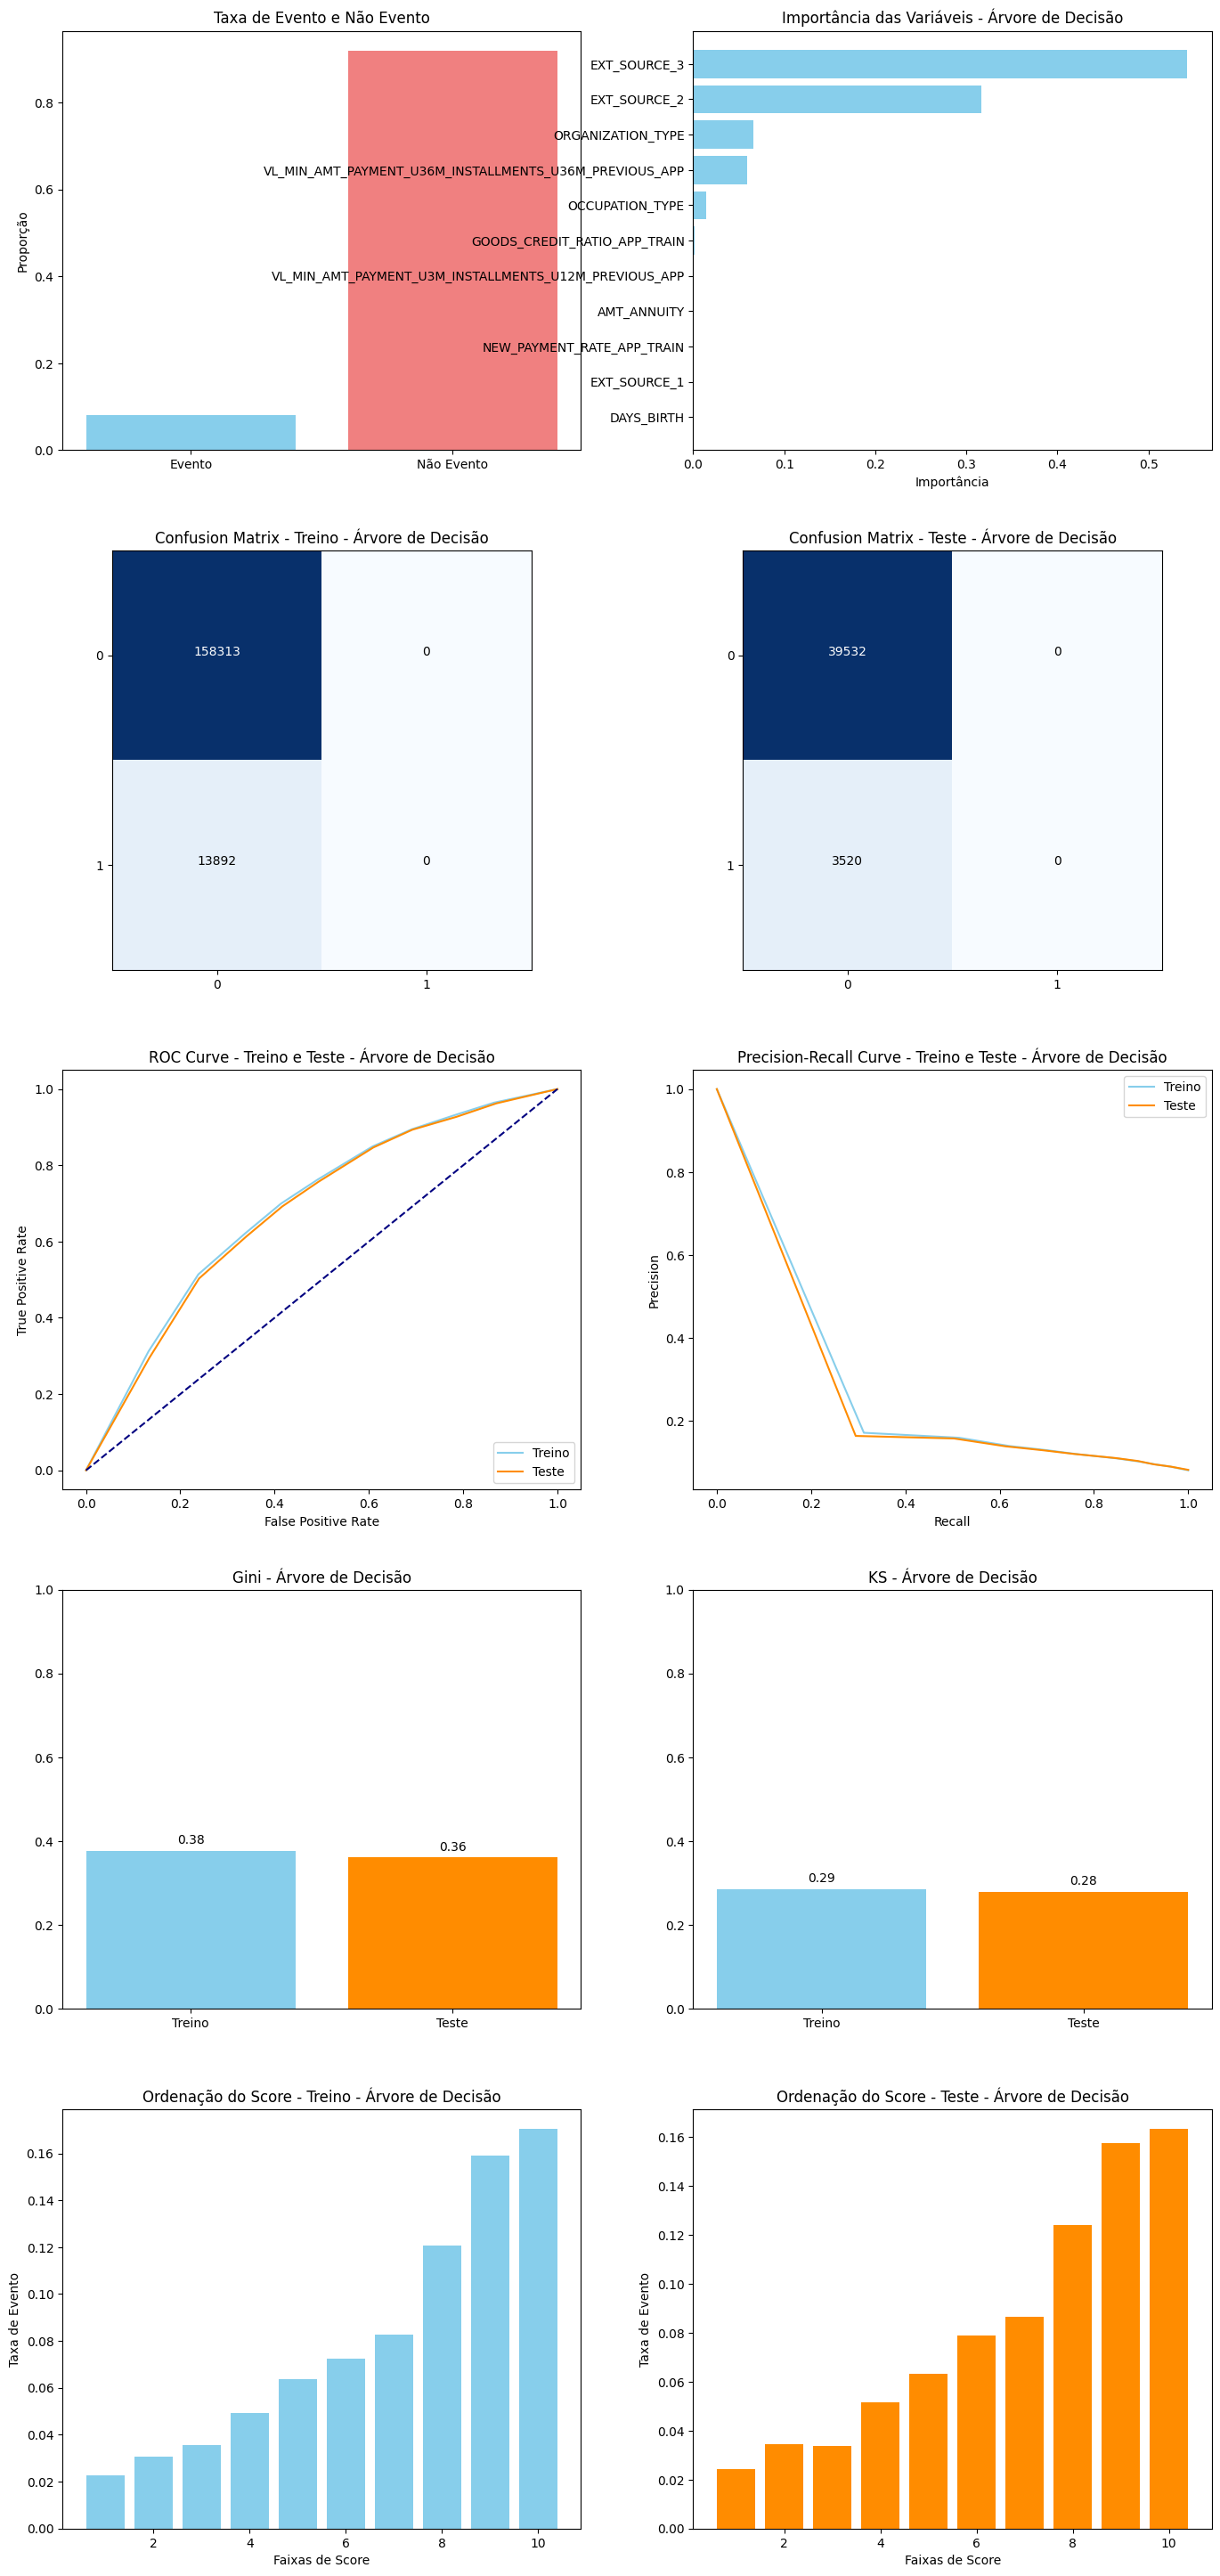

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt, nm_modelo='Árvore de Decisão')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: Random Forest**

In [ ]:
# Função que define os parâmetros do modelo e o que o Optuna deve otimizar.
def objective_rf(trial):
  param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

  # Treinamento e avaliação do modelo.
  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  preprocessor = StandardScaler()
  avg_roc = 0
  for tr, ts in cv.split(X_train, y_train):
    Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
    ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
    model = RandomForestClassifier(**param, random_state=42)
    Xtr_processed = pd.DataFrame(preprocessor.fit_transform(Xtr, ytr), columns=X_train.columns)
    Xvl_processed = pd.DataFrame(preprocessor.transform(Xvl), columns=X_test.columns)
    model.fit(Xtr_processed, ytr)
    p = model.predict_proba(Xvl_processed)[:, 1]
    avg_roc += roc_auc_score(yvl, p)

  return avg_roc / 5

# Criando um estudo Optuna com o objetivo de maximizar a AUC-ROC.
study = optuna.create_study(direction='maximize', study_name='model_rf', storage='sqlite:///modelo_rf.db')
study.add_trials(study.trials)
try:
    study.optimize(objective_rf, timeout=1200, callbacks=[early_stopping_opt])

# Recarregar um estudo Optuna salvo anteriormente e continuar a otimização.
#study = optuna.load_study(study_name='model_rf', storage='sqlite:///modelo_rf.db')
#study.optimize(objective_rf, timeout=1200, callbacks=[early_stopping_opt])

# Printando a mensagem de limite excedido.
except EarlyStoppingExceeded:
    print('')
    print(Fore.BLACK + Style.BRIGHT + f'Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas {OPTUNA_EARLY_STOPING} iterações' + Style.RESET_ALL)

# Printando as informações dos testes.
print('')
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print('Número de testes finalizados: {}'.format(len(study.trials)))
print('')

print('Melhor teste: ')
trial = study.best_trial

print('  Melhor AUC: {}'.format(trial.value))
print('')

print('  Melhores Parâmetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
print('')
print('=' * 150 + Style.RESET_ALL)

[I 2024-05-08 16:00:29,107] A new study created in RDB with name: model_rf
[I 2024-05-08 16:01:00,683] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 304, 'max_depth': 12, 'min_samples_split': 0.2834905649838921, 'min_samples_leaf': 0.4704639773905921, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5.
[I 2024-05-08 16:01:44,921] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 433, 'max_depth': 11, 'min_samples_split': 0.03940072302917875, 'min_samples_leaf': 0.49515698885572657, 'max_features': 'log2'}. Best is trial 0 with value: 0.5.
[I 2024-05-08 16:02:14,165] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 261, 'max_depth': 14, 'min_samples_split': 0.15321797805419812, 'min_samples_leaf': 0.4982151458384925, 'max_features': 'log2'}. Best is trial 0 with value: 0.5.
[I 2024-05-08 16:04:10,678] Trial 3 finished with value: 0.7098085014607843 and parameters: {'n_estimators': 357, 'max_depth': 6, 'min_samples_split': 0.2992


                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Número de testes finalizados: 22

Melhor teste: 
  Melhor AUC: 0.72078484900226

  Melhores Parâmetros: 
    n_estimators: 109
    max_depth: 4
    min_samples_split: 0.0854038983869737
    min_samples_leaf: 0.09217424469875689
    max_features: log2



In [ ]:
# Treino do modelo com os melhores parâmetros.
best_model_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features='log2',
                       min_samples_leaf=0.09217424469875689,
                       min_samples_split=0.0854038983869737, n_estimators=109,
                       random_state=42)

#### **Avaliando o modelo (Random Forest)**

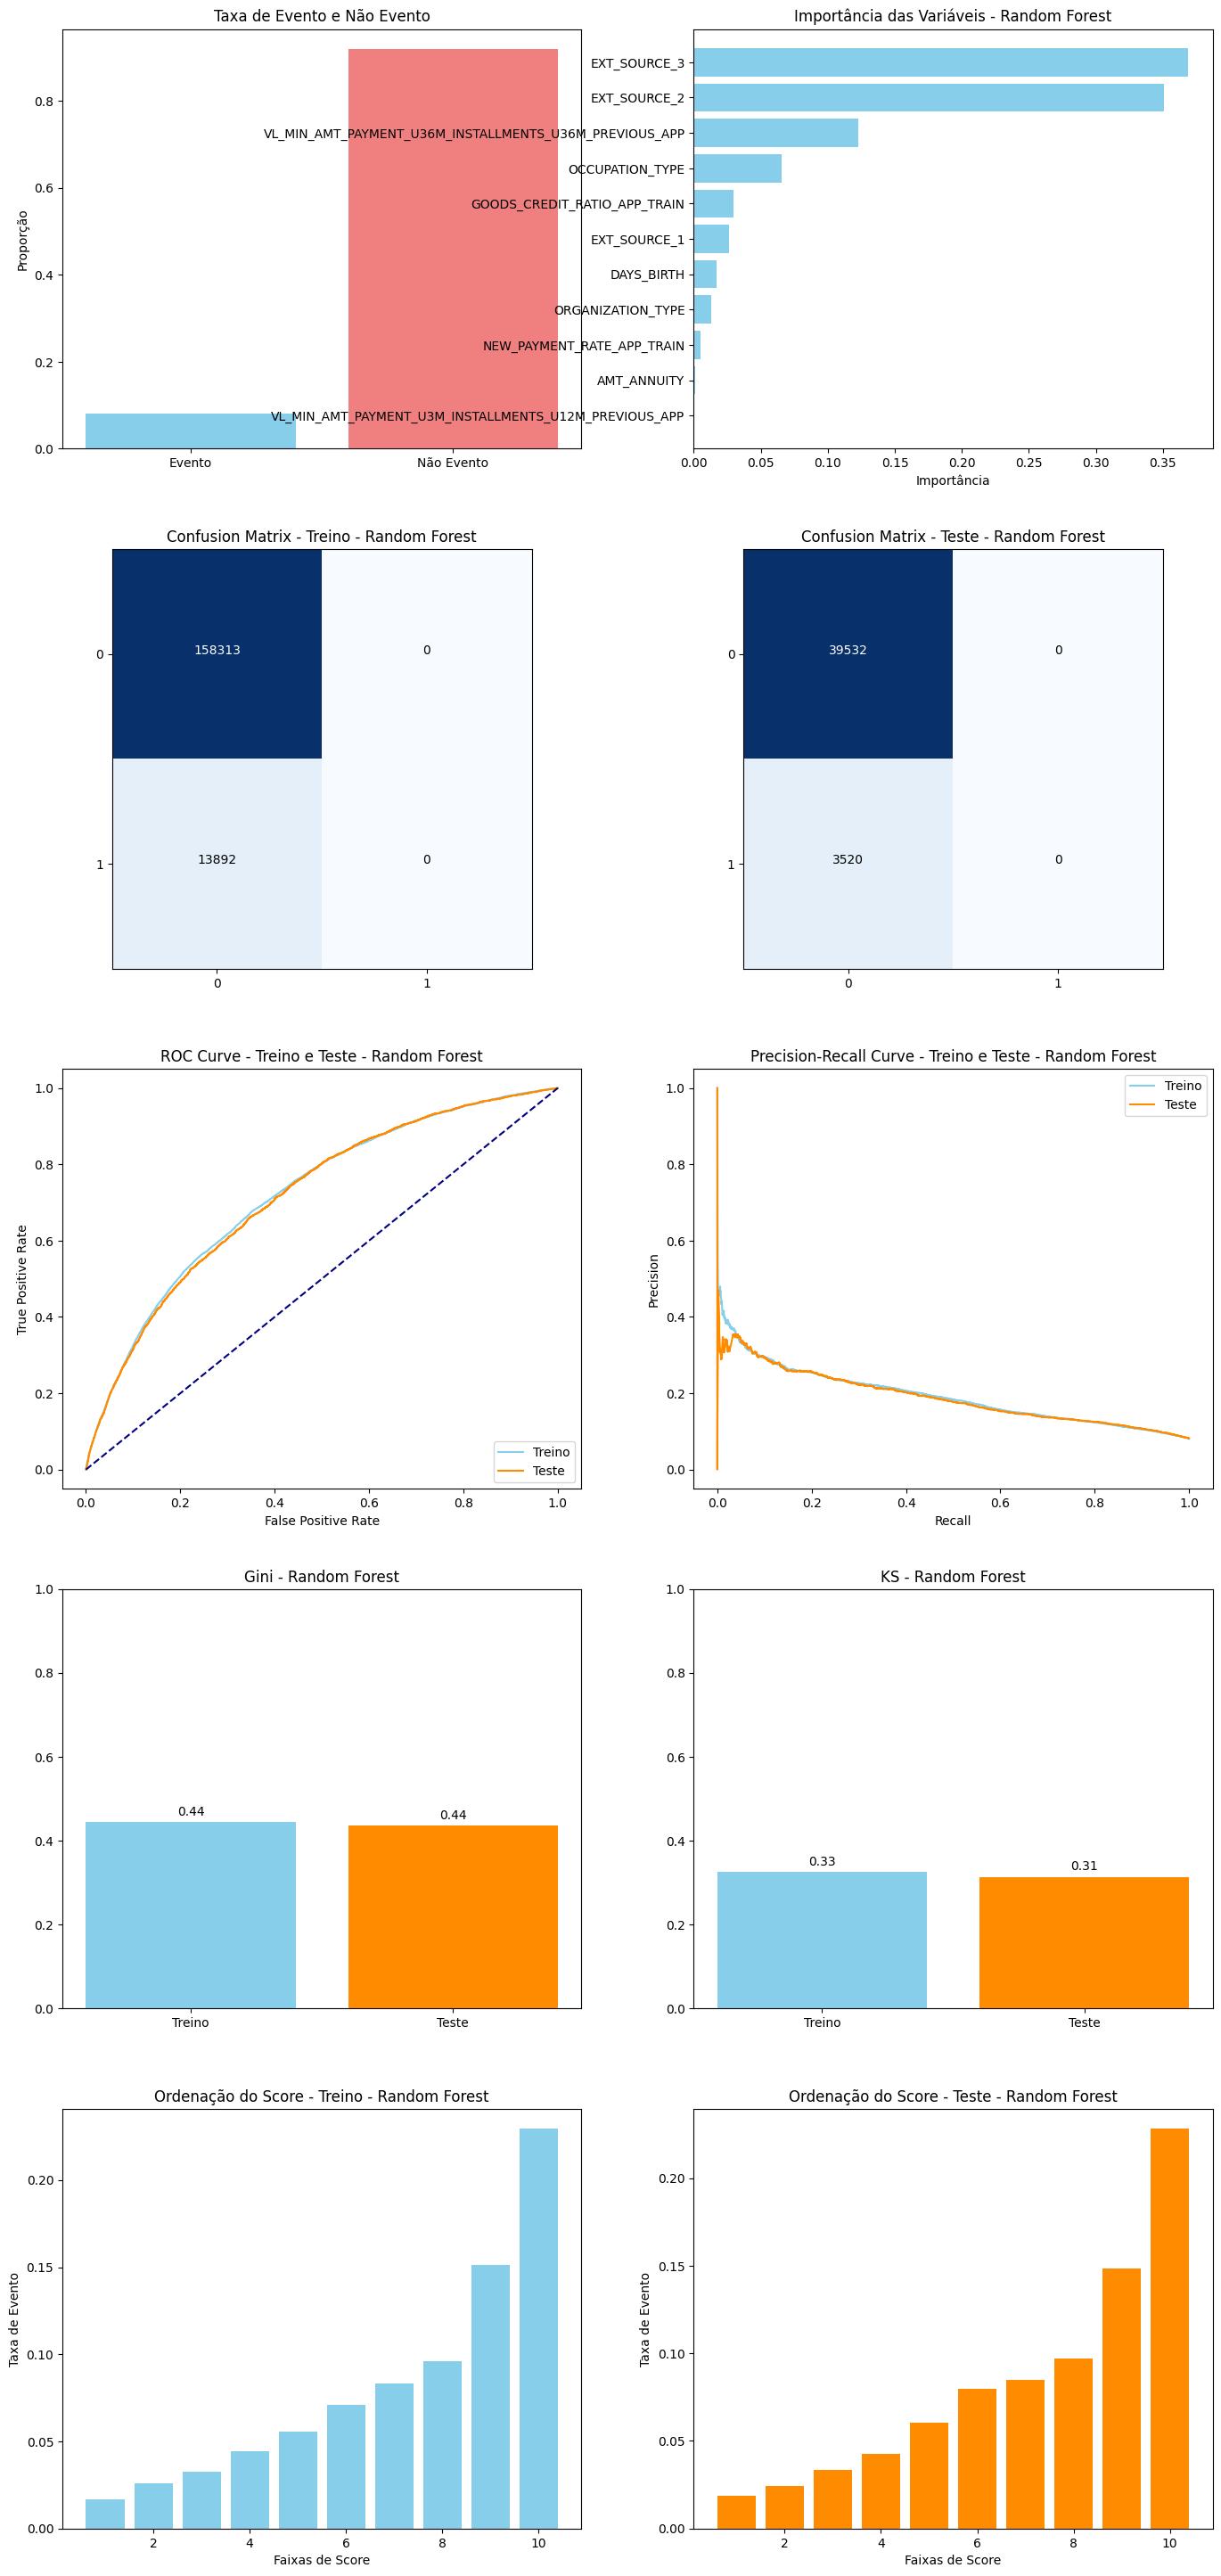

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf, nm_modelo='Random Forest')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: Gradient Boosting**

In [ ]:
# Função que define os parâmetros do modelo e o que o Optuna deve otimizar.
def objective_gb(trial):
  param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.05, 0.2),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.05, 0.2),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
    }

  # Treinamento e avaliação do modelo.
  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  preprocessor = StandardScaler()
  avg_roc = 0
  for tr, ts in cv.split(X_train, y_train):
    Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
    ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
    model = GradientBoostingClassifier(**param, random_state=42)
    Xtr_processed = pd.DataFrame(preprocessor.fit_transform(Xtr, ytr), columns=X_train.columns)
    Xvl_processed = pd.DataFrame(preprocessor.transform(Xvl), columns=X_test.columns)
    model.fit(Xtr_processed, ytr)
    p = model.predict_proba(Xvl_processed)[:, 1]
    avg_roc += roc_auc_score(yvl, p)

  return avg_roc / 5

# Criando um estudo Optuna com o objetivo de maximizar a AUC-ROC.
study = optuna.create_study(direction='maximize', study_name='model_gb', storage='sqlite:///modelo_gb.db')
study.add_trials(study.trials)
try:
    study.optimize(objective_gb, timeout=1200, callbacks=[early_stopping_opt])

# Recarregar um estudo Optuna salvo anteriormente e continuar a otimização.
#study = optuna.load_study(study_name='model_gb', storage='sqlite:///modelo_gb.db')
#study.optimize(objective_gb, timeout=1200, callbacks=[early_stopping_opt])

# Printando a mensagem de limite excedido.
except EarlyStoppingExceeded:
    print('')
    print(Fore.BLACK + Style.BRIGHT + f'Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas {OPTUNA_EARLY_STOPING} iterações' + Style.RESET_ALL)

# Printando as informações dos testes.
print('')
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print('Número de testes finalizados: {}'.format(len(study.trials)))
print('')

print('Melhor teste: ')
trial = study.best_trial

print('  Melhor AUC: {}'.format(trial.value))
print('')

print('  Melhores Parâmetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
print('')
print('=' * 150 + Style.RESET_ALL)

[I 2024-05-08 16:27:44,698] A new study created in RDB with name: model_gb_01
[I 2024-05-08 16:31:34,136] Trial 0 finished with value: 0.6906216010827986 and parameters: {'n_estimators': 209, 'learning_rate': 0.0028470151708683603, 'max_depth': 3, 'min_samples_split': 0.07116082898913889, 'min_samples_leaf': 0.1954401519433921, 'max_features': None, 'subsample': 0.7057995222795239}. Best is trial 0 with value: 0.6906216010827986.



Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas 20 iterações

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Número de testes finalizados: 1

Melhor teste: 
  Melhor AUC: 0.6906216010827986

  Melhores Parâmetros: 
    n_estimators: 209
    learning_rate: 0.0028470151708683603
    max_depth: 3
    min_samples_split: 0.07116082898913889
    min_samples_leaf: 0.1954401519433921
    max_features: None
    subsample: 0.7057995222795239



In [ ]:
# Treino do modelo com os melhores parâmetros.
best_model_gb = GradientBoostingClassifier(**study.best_params, random_state=42)
best_model_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.0028470151708683603,
                           min_samples_leaf=0.1954401519433921,
                           min_samples_split=0.07116082898913889,
                           n_estimators=209, random_state=42,
                           subsample=0.7057995222795239)

#### **Avaliando o modelo (Gradient Boosting)**

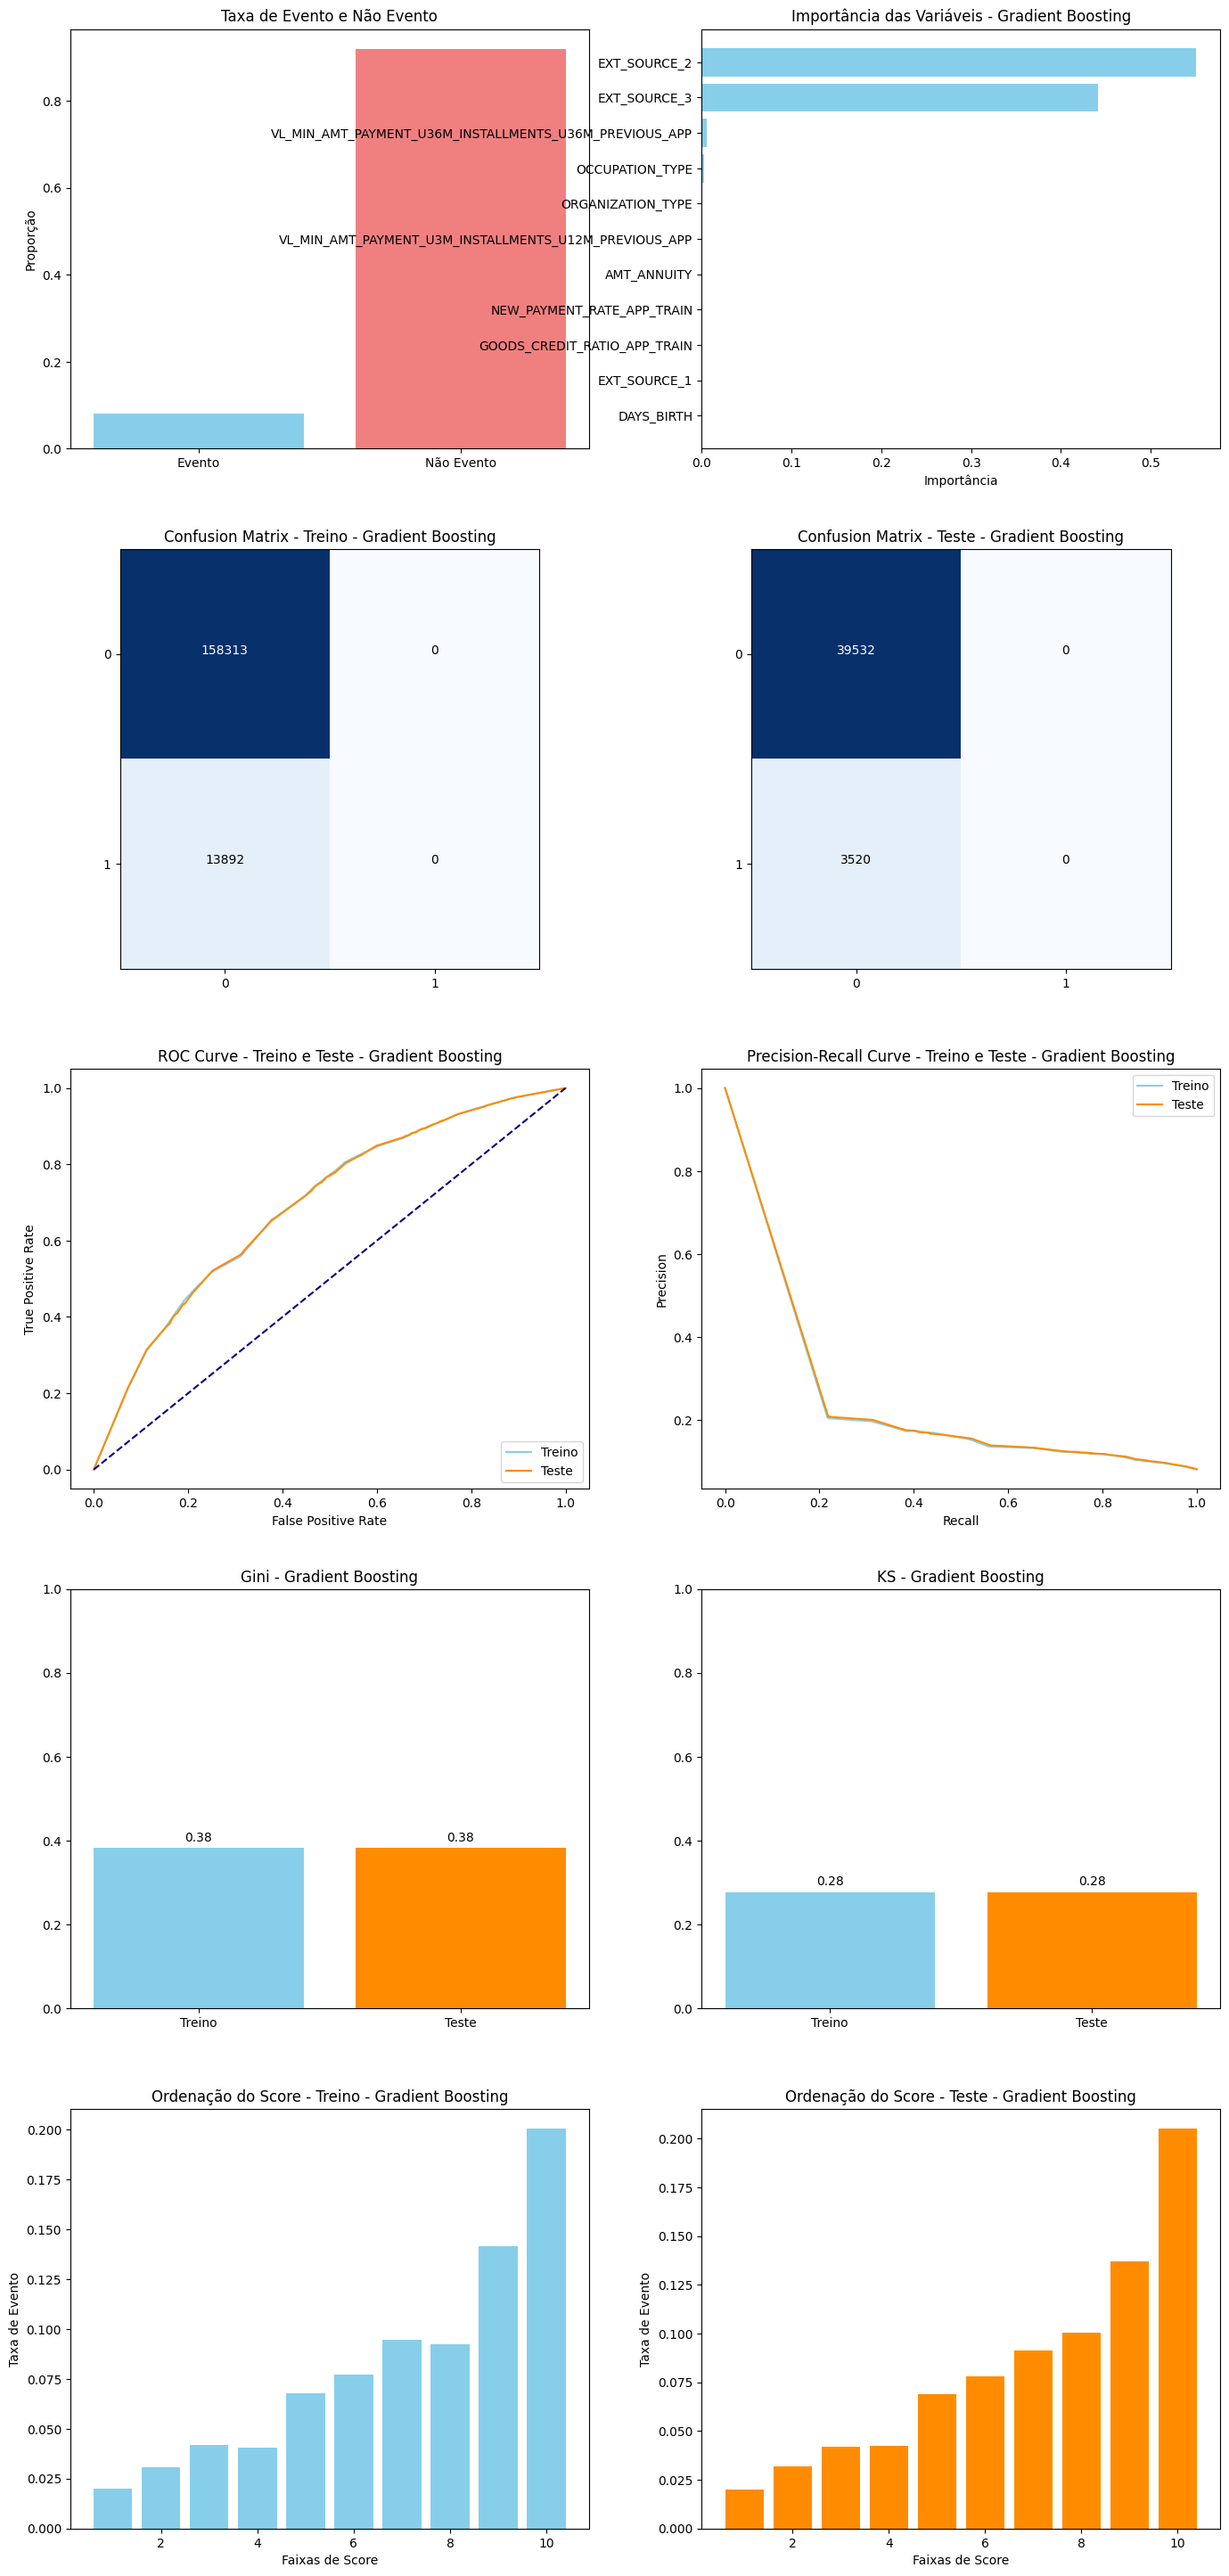

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_gb, nm_modelo='Gradient Boosting')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: LightGBM (Light Gradient Boosting Machine)**

In [ ]:
# Função que define os parâmetros do modelo e o que o Optuna deve otimizar.
def objective_lgbm(trial):
  param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 64, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'max_bin': trial.suggest_int('max_bin', 100, 500),
        'cat_smooth': trial.suggest_float('cat_smooth', 0.1, 10.0),
    }

  # Treinamento e avaliação do modelo.
  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  preprocessor = StandardScaler()
  avg_roc = 0
  for tr, ts in cv.split(X_train, y_train):
    Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
    ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
    model = lgb.LGBMClassifier(**param, random_state=42)
    Xtr_processed = pd.DataFrame(preprocessor.fit_transform(Xtr, ytr), columns=X_train.columns)
    Xvl_processed = pd.DataFrame(preprocessor.transform(Xvl), columns=X_test.columns)
    model.fit(Xtr_processed, ytr)
    p = model.predict_proba(Xvl_processed)[:, 1]
    avg_roc += roc_auc_score(yvl, p)

  return avg_roc / 5

# Criando um estudo Optuna com o objetivo de maximizar a AUC-ROC.
study = optuna.create_study(direction='maximize', study_name='model_lgbm', storage='sqlite:///modelo_lgbm.db')
study.add_trials(study.trials)
try:
    study.optimize(objective_lgbm, timeout=2400, callbacks=[early_stopping_opt])

# Recarregar um estudo Optuna salvo anteriormente e continuar a otimização.
#study = optuna.load_study(study_name='model_lgbm', storage='sqlite:///modelo_lgbm.db')
#study.optimize(objective_lgbm, timeout=2400, callbacks=[early_stopping_opt])

# Printando a mensagem de limite excedido.
except EarlyStoppingExceeded:
    print('')
    print(Fore.BLACK + Style.BRIGHT + f'Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas {OPTUNA_EARLY_STOPING} iterações' + Style.RESET_ALL)

# Printando as informações dos testes.
print('')
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print('Número de testes finalizados: {}'.format(len(study.trials)))
print('')

print('Melhor teste: ')
trial = study.best_trial

print('  Melhor AUC: {}'.format(trial.value))
print('')

print('  Melhores Parâmetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
print('')
print('=' * 150 + Style.RESET_ALL)

[I 2024-05-08 16:32:31,088] A new study created in RDB with name: model_lgbm
[I 2024-05-08 16:32:47,457] Trial 0 finished with value: 0.7548460547404909 and parameters: {'lambda_l1': 0.7704723330886086, 'lambda_l2': 0.2557592279390067, 'num_leaves': 161, 'feature_fraction': 0.5912582312499669, 'bagging_fraction': 0.8858124434989026, 'bagging_freq': 9, 'learning_rate': 0.041947154541619666, 'max_depth': 6, 'min_gain_to_split': 0.15790754828585152, 'min_data_in_leaf': 39, 'max_bin': 188, 'cat_smooth': 3.56025414830064}. Best is trial 0 with value: 0.7548460547404909.
[I 2024-05-08 16:32:59,641] Trial 1 finished with value: 0.7449423690437491 and parameters: {'lambda_l1': 0.5032930920924671, 'lambda_l2': 0.03656960770463624, 'num_leaves': 106, 'feature_fraction': 0.12795401697126219, 'bagging_fraction': 0.806575895005602, 'bagging_freq': 8, 'learning_rate': 0.015025737170028437, 'max_depth': 10, 'min_gain_to_split': 0.6264309325589282, 'min_data_in_leaf': 77, 'max_bin': 131, 'cat_smooth':


Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas 20 iterações

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Número de testes finalizados: 22

Melhor teste: 
  Melhor AUC: 0.7596724604190388

  Melhores Parâmetros: 
    lambda_l1: 0.2955234260959133
    lambda_l2: 0.6918540639132091
    num_leaves: 186
    feature_fraction: 0.653542896018615
    bagging_fraction: 0.7478550945138966
    bagging_freq: 6
    learning_rate: 0.09841470252032948
    max_depth: 5
    min_gain_to_split: 0.7979756858994522
    min_data_in_leaf: 100
    max_bin: 372
    cat_smooth: 2.065055134960545



In [ ]:
# Treino do modelo com os melhores parâmetros.
best_model_lgbm = lgb.LGBMClassifier(**study.best_params, random_state=42)
best_model_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.7979756858994522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7979756858994522
[LightGBM] [Warning] feature_fraction is set=0.653542896018615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653542896018615
[LightGBM] [Warning] lambda_l2 is set=0.6918540639132091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918540639132091
[LightGBM] [Warning] lambda_l1 is set=0.2955234260959133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2955234260959133
[LightGBM] [Warning] bagging_fraction is set=0.7478550945138966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478550945138966
[LightGBM] [Warning] min_data_in_leaf is set=100

LGBMClassifier(bagging_fraction=0.7478550945138966, bagging_freq=6,
               cat_smooth=2.065055134960545, feature_fraction=0.653542896018615,
               lambda_l1=0.2955234260959133, lambda_l2=0.6918540639132091,
               learning_rate=0.09841470252032948, max_bin=372, max_depth=5,
               min_data_in_leaf=100, min_gain_to_split=0.7979756858994522,
               num_leaves=186, random_state=42)

#### **Avaliando o modelo (LightGBM)**

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.7979756858994522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7979756858994522
[LightGBM] [Warning] feature_fraction is set=0.653542896018615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653542896018615
[LightGBM] [Warning] lambda_l2 is set=0.6918540639132091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918540639132091
[LightGBM] [Warning] lambda_l1 is set=0.2955234260959133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2955234260959133
[LightGBM] [Warning] bagging_fraction is set=0.7478550945138966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478550945138966
[LightGBM] [Warning] min_data_in_leaf is set=100

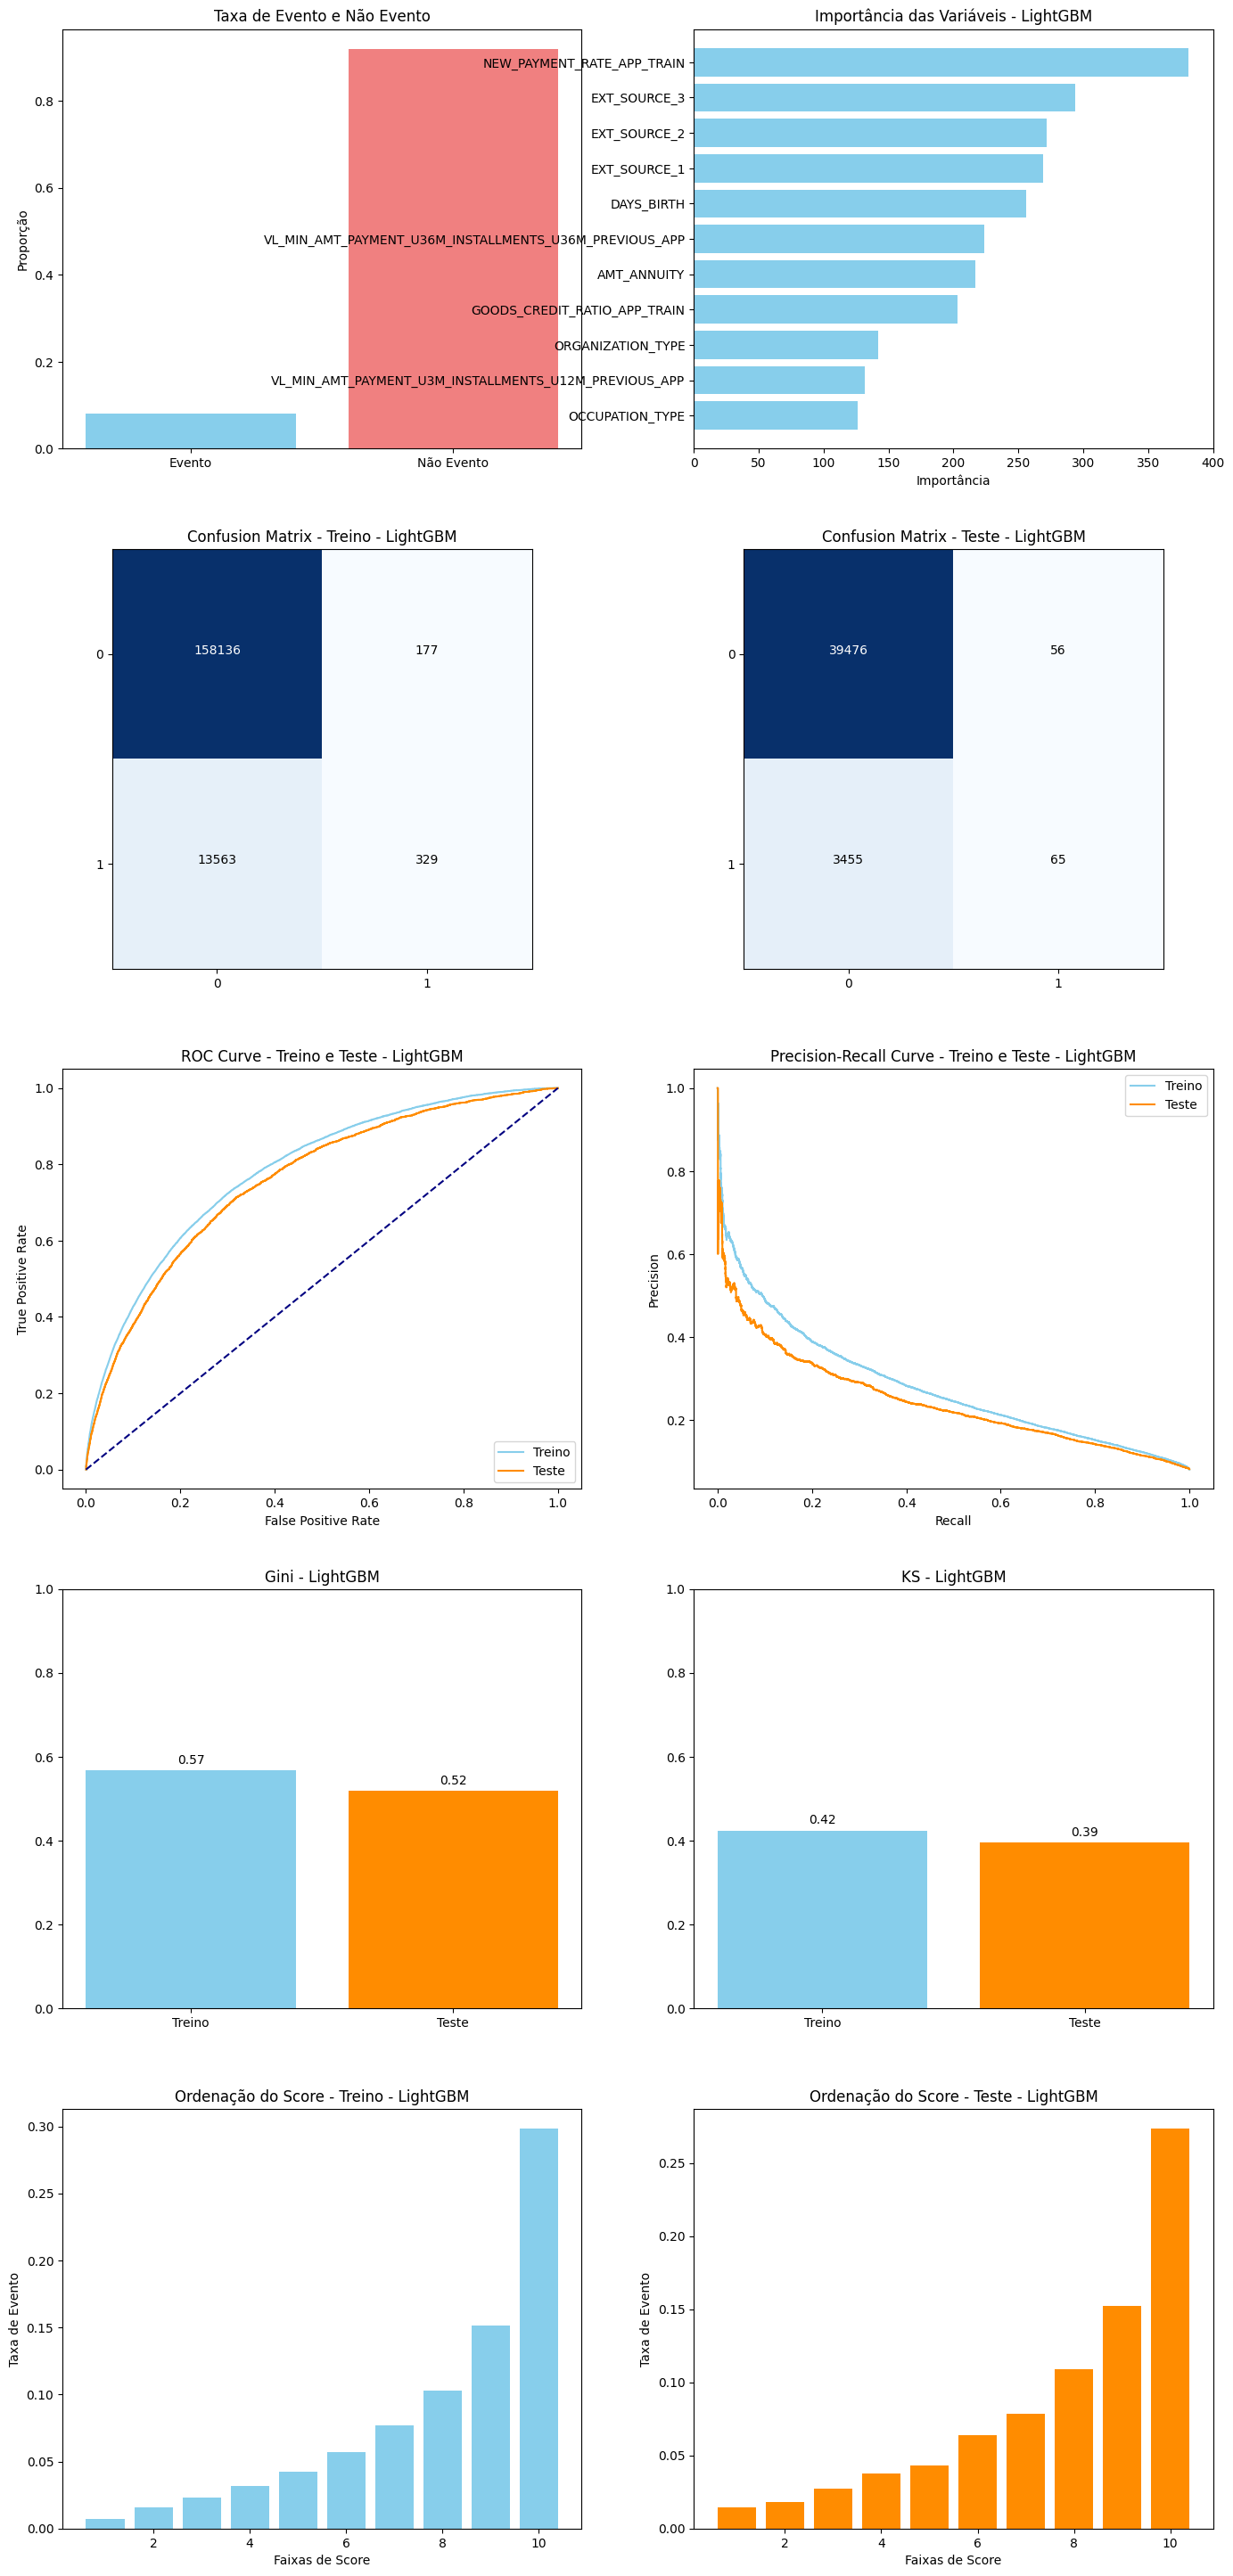

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lgbm, nm_modelo='LightGBM')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: XGBoost (eXtreme Gradient Boosting)**

In [ ]:
# Função que define os parâmetros do modelo e o que o Optuna deve otimizar.
def objective_xgb(trial):
  param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
    'booster': 'gbtree',
    'lambda': trial.suggest_float('lambda', 0.01, 10.0),
    'alpha': trial.suggest_float('alpha', 0.01, 10.0),
    'max_depth': trial.suggest_int('max_depth', 3, 10),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
    'eta': trial.suggest_float('eta', 0.01, 0.3),
    'gamma': trial.suggest_float('gamma', 0.01, 1.0),
    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    'max_leaves': trial.suggest_int('max_leaves', 256, 1024),
    'max_bin': trial.suggest_int('max_bin', 256, 1024),
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
    'tree_method': 'hist'
    }

  # Treinamento e avaliação do modelo.
  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
  preprocessor = StandardScaler()
  avg_roc = 0
  for tr, ts in cv.split(X_train, y_train):
    Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
    ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
    model = XGBClassifier(**param, random_state=42)
    Xtr_processed = pd.DataFrame(preprocessor.fit_transform(Xtr, ytr), columns=X_train.columns)
    Xvl_processed = pd.DataFrame(preprocessor.transform(Xvl), columns=X_test.columns)
    model.fit(Xtr_processed, ytr)
    p = model.predict_proba(Xvl_processed)[:, 1]
    avg_roc += roc_auc_score(yvl, p)

  return avg_roc / 5

# Criando um estudo Optuna com o objetivo de maximizar a AUC-ROC.
study = optuna.create_study(direction='maximize', study_name='model_xgb', storage='sqlite:///modelo_xgb.db')
study.add_trials(study.trials)
try:
    study.optimize(objective_xgb, timeout=2400, callbacks=[early_stopping_opt])

# Recarregar um estudo Optuna salvo anteriormente e continuar a otimização.
#study = optuna.load_study(study_name='model_xgb', storage='sqlite:///modelo_xgb.db')
#study.optimize(objective_xgb, timeout=2400, callbacks=[early_stopping_opt])

# Printando a mensagem de limite excedido.
except EarlyStoppingExceeded:
    print('')
    print(Fore.BLACK + Style.BRIGHT + f'Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas {OPTUNA_EARLY_STOPING} iterações' + Style.RESET_ALL)

# Printando as informações dos testes.
print('')
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print('Número de testes finalizados: {}'.format(len(study.trials)))
print('')

print('Melhor teste: ')
trial = study.best_trial

print('  Melhor AUC: {}'.format(trial.value))
print('')

print('  Melhores Parâmetros: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
print('')
print('=' * 150 + Style.RESET_ALL)

[I 2024-05-08 16:37:48,421] A new study created in RDB with name: model_xgb
[I 2024-05-08 16:37:58,585] Trial 0 finished with value: 0.7580830952296472 and parameters: {'lambda': 9.150892489291273, 'alpha': 3.1297576020127673, 'max_depth': 4, 'subsample': 0.5718782222287246, 'colsample_bytree': 0.9479792753705323, 'min_child_weight': 3.3634920374254875, 'eta': 0.20768732542394308, 'gamma': 0.01271048763517189, 'grow_policy': 'lossguide', 'max_leaves': 735, 'max_bin': 667, 'scale_pos_weight': 4.7566788803174465}. Best is trial 0 with value: 0.7580830952296472.
[I 2024-05-08 16:38:15,500] Trial 1 finished with value: 0.7567611965326402 and parameters: {'lambda': 2.214696604183225, 'alpha': 0.7089741125547296, 'max_depth': 7, 'subsample': 0.9187836455310909, 'colsample_bytree': 0.916674210813933, 'min_child_weight': 5.695280769740944, 'eta': 0.05075350177280871, 'gamma': 0.3046918890946594, 'grow_policy': 'lossguide', 'max_leaves': 754, 'max_bin': 729, 'scale_pos_weight': 1.60981101510037


Limite de Parada Antecipada Excedido: Nenhum novo melhor resultado objetivo nas últimas 20 iterações

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Número de testes finalizados: 22

Melhor teste: 
  Melhor AUC: 0.7604734255972808

  Melhores Parâmetros: 
    lambda: 5.005789967925523
    alpha: 5.672570918593209
    max_depth: 5
    subsample: 0.789747440596746
    colsample_bytree: 0.5580235889283456
    min_child_weight: 4.494619376548708
    eta: 0.14894168483037754
    gamma: 0.7544485084382566
    grow_policy: depthwise
    max_leaves: 821
    max_bin: 433
    scale_pos_weight: 3.8363533800992498



In [ ]:
# Treino do modelo com os melhores parâmetros.
best_model_xgb = XGBClassifier(**study.best_params, random_state=42)
best_model_xgb.fit(X_train, y_train)

XGBClassifier(alpha=5.672570918593209, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5580235889283456, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.14894168483037754, eval_metric=None, feature_types=None,
              gamma=0.7544485084382566, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=5.005789967925523, learning_rate=None, max_bin=433,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=821,
              min_child_weight=4.494619376548708, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

#### **Avaliando o modelo (XGBoost)**

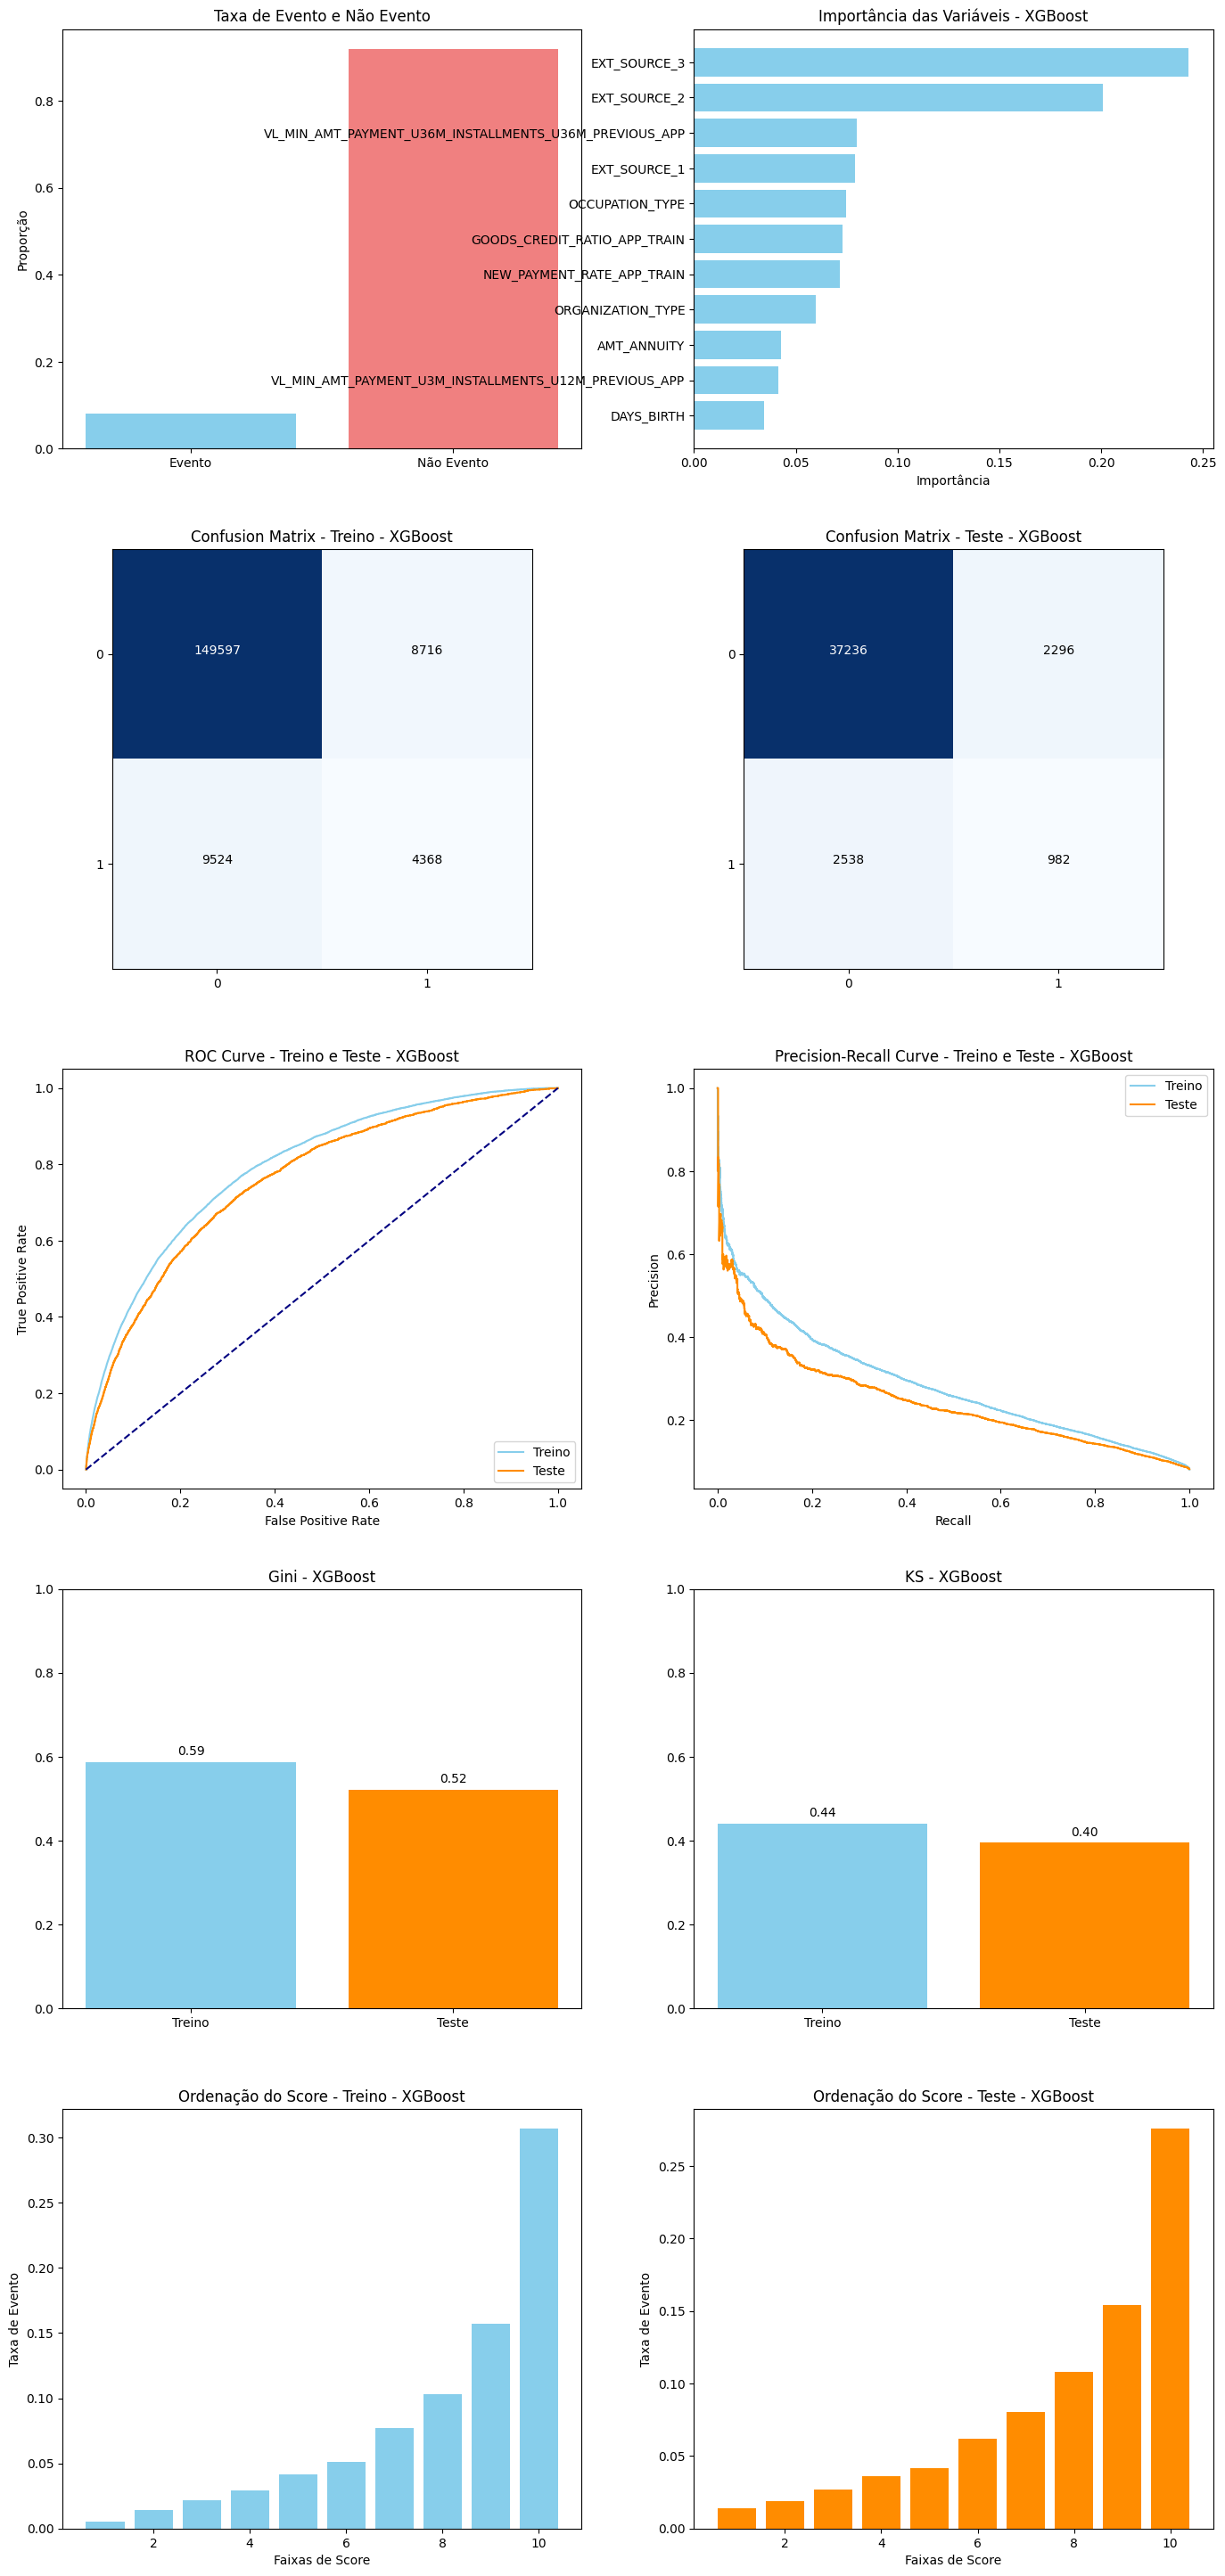

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_xgb, nm_modelo='XGBoost')

<br>
<br>
<br>
<br>

## **Comparação das métricas dos modelos treinados (base de teste)**

In [ ]:
# Criando uma lista com os modelos treinados.
models = {'Decision Tree': best_model_dt,
          'Random Forest': best_model_rf,
          'Gradient Boosting': best_model_gb,
          'LightGBM': best_model_lgbm,
          'XGBoost': best_model_xgb,
         }

# Chamando a função com os datasets de treino e teste e os modelos carregados.
metrics_df = evaluate_models(X_train, y_train, X_test, y_test, models)

metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_gain_to_split is set=0.7979756858994522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7979756858994522
[LightGBM] [Warning] feature_fraction is set=0.653542896018615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.653542896018615
[LightGBM] [Warning] lambda_l2 is set=0.6918540639132091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6918540639132091
[LightGBM] [Warning] lambda_l1 is set=0.2955234260959133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2955234260959133
[LightGBM] [Warning] bagging_fraction is set=0.7478550945138966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478550945138966
[LightGBM] [Warning] min_data_in_leaf is set=100

,Model,AUC-ROC,Accuracy,Precision,Recall,F1 Score,Gini,KS,Training_Time(s)
4,XGBoost,0.761009,0.887717,0.299573,0.278977,0.288909,0.522019,0.395178,0.574222
3,LightGBM,0.759039,0.918447,0.537190,0.018466,0.035704,0.518079,0.394952,2.434245
1,Random Forest,0.717824,0.918238,0.000000,0.000000,0.000000,0.435649,0.313927,2.405357
2,Gradient Boosting,0.691371,0.918238,0.000000,0.000000,0.000000,0.382742,0.277515,1.482486
0,Decision Tree,0.680878,0.918238,0.000000,0.000000,0.000000,0.361756,0.280095,0.131397


<br>

**Modelo escolhido com base nas métricas AUC-ROC, Gini e KS:** XGBoost

In [ ]:
# Definindo o modelo escolhido e o nome do modelo.
model = best_model_xgb
name_model = 'XGBoost'

In [ ]:
# Salvando o modelo escolhido em um arquivo .pkl (artefato).
with open(dir_pkl + '/model_optuna_XGBoost.pkl', 'wb') as file:
  pickle.dump(model, file)

<br>
<br>
<br>
<br>

## **Métricas do modelo escolhido**

In [ ]:
# Chamando a função para métricas.
df_metrics = calculate_metrics_01(name_model, model, X_train, y_train, X_test, y_test)
df_metrics

,Algoritmo,Conjunto,Acuracia,Precision,Recall,AUC_ROC,GINI,KS
0,XGBoost,Treino,0.894080,0.333843,0.314426,0.793610,0.587220,0.440956
1,XGBoost,Teste,0.887717,0.299573,0.278977,0.761009,0.522019,0.395178


In [ ]:
# Criando tabela com as taxas de evento para cada faixa, para o conjunto de treino.
y_train.index = X_train.index
bins = 10
tab_train = pd.concat([X_train, y_train], axis=1).copy()
tab_train['score'] = model.predict_proba(tab_train.drop(columns=['TARGET']))[:,0]
tab_train['decile'] = pd.qcut(tab_train['score'], bins, labels=False)

table_train = tab_train.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab_train[tab_train.TARGET == 1].shape[0])
).reset_index()
table_train['min_score'] = 1000 * table_train['min_score']
table_train['max_score'] = 1000 * table_train['max_score']
table_train = table_train[['decile','event_rate','perc_total_bads']]
table_train.columns = ['decile','event_rate_train','perc_total_bads_train']


# Criando tabela com as taxas de evento para cada faixa, para o conjunto de teste.
y_test.index = X_test.index
bins = 10
tab_test = pd.concat([X_test, y_test], axis=1).copy()
tab_test['score'] = model.predict_proba(tab_test.drop(columns=['TARGET']))[:,0]
tab_test['decile'] = pd.qcut(tab_test['score'], bins, labels=False)

table_test = tab_test.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab_test[tab_test.TARGET == 1].shape[0])
).reset_index()
table_test['min_score'] = 1000 * table_test['min_score']
table_test['max_score'] = 1000 * table_test['max_score']
table_test = table_test[['decile','event_rate','perc_total_bads']]
table_test.columns = ['decile','event_rate_test','perc_total_bads_test']


# Unificando as tabelas.
summary = pd.merge(table_train, table_test, on='decile', how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.306544,0.380003,0.275662,0.337216
1,1,0.157027,0.194644,0.154007,0.188352
2,2,0.103014,0.127699,0.108014,0.132102
3,3,0.077178,0.095667,0.080139,0.098011
4,4,0.051217,0.063490,0.062253,0.076136
5,5,0.041870,0.051900,0.041115,0.050284
6,6,0.029210,0.036208,0.036469,0.044602
7,7,0.021369,0.026490,0.027178,0.033239
8,8,0.014170,0.017564,0.019048,0.023295
9,9,0.005110,0.006335,0.013702,0.016761


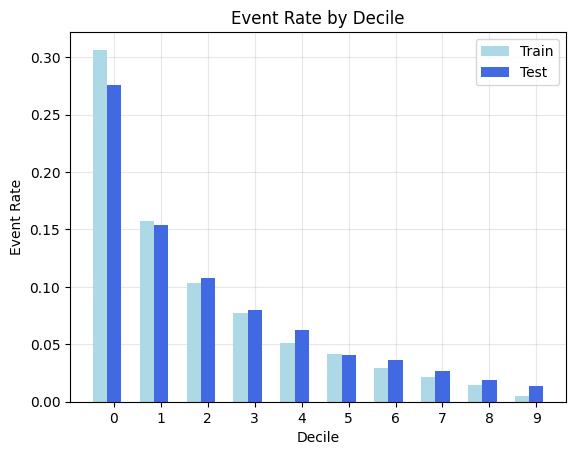

In [ ]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.grid(axis='x', linestyle='-', alpha=0.3)
plt.gca().set_axisbelow(True)
plt.legend()
plt.show()

<br>
<br>
<br>
<br>

## **Análise das faixas de score e apetite de risco**

In [ ]:
# Fazendo uma cópia dos DataFrames.
X_train_01 = X_train.copy()
y_train_01 = y_train.copy()

X_test_01 = X_test.copy()
y_test_01 = y_test.copy()

# Prevendo a probabilidade de evento.
X_train_01['Score_1'] = model.predict_proba(X_train)[:, 1].round(4)
X_test_01['Score_1'] = model.predict_proba(X_test)[:, 1].round(4)

# Calculando a probabilidade de não evento.
X_train_01['Score_0'] = 1 - X_train_01['Score_1']
X_test_01['Score_0'] = 1 - X_test_01['Score_1']

<br>

### **Treino**

**Apetite de risco de 8,0% (atual da carteira)**

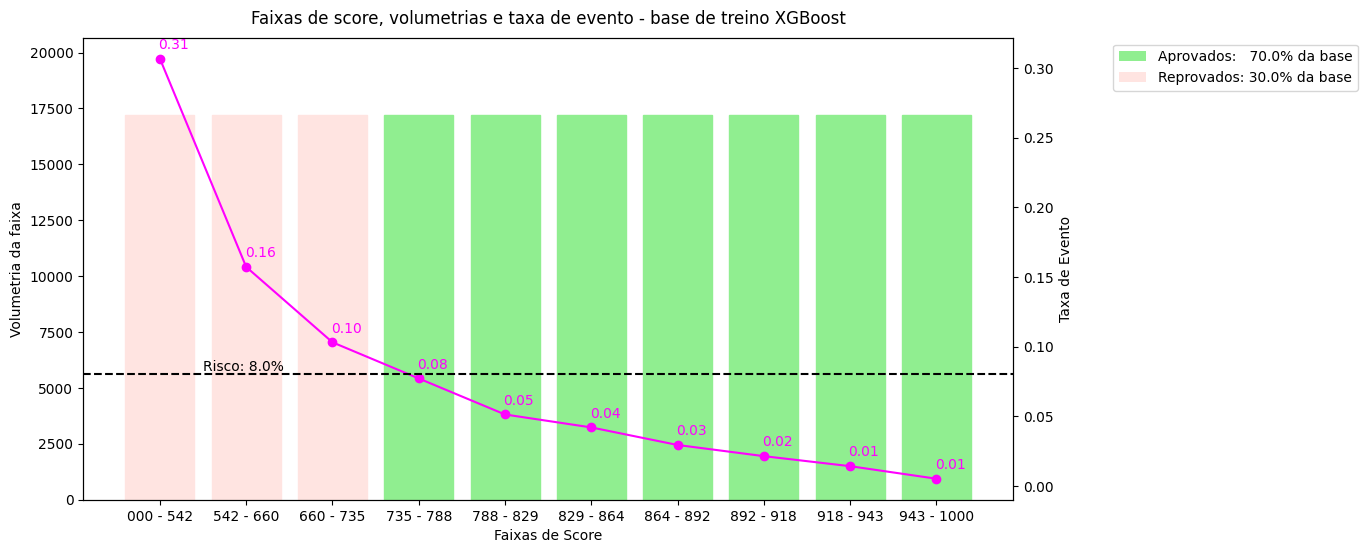

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 8,0%.
faixas_treino_8 = carteira_treino_rl(model, name_model, risk = 0.08, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

**Apetite de risco de 5,0% (conservador)**

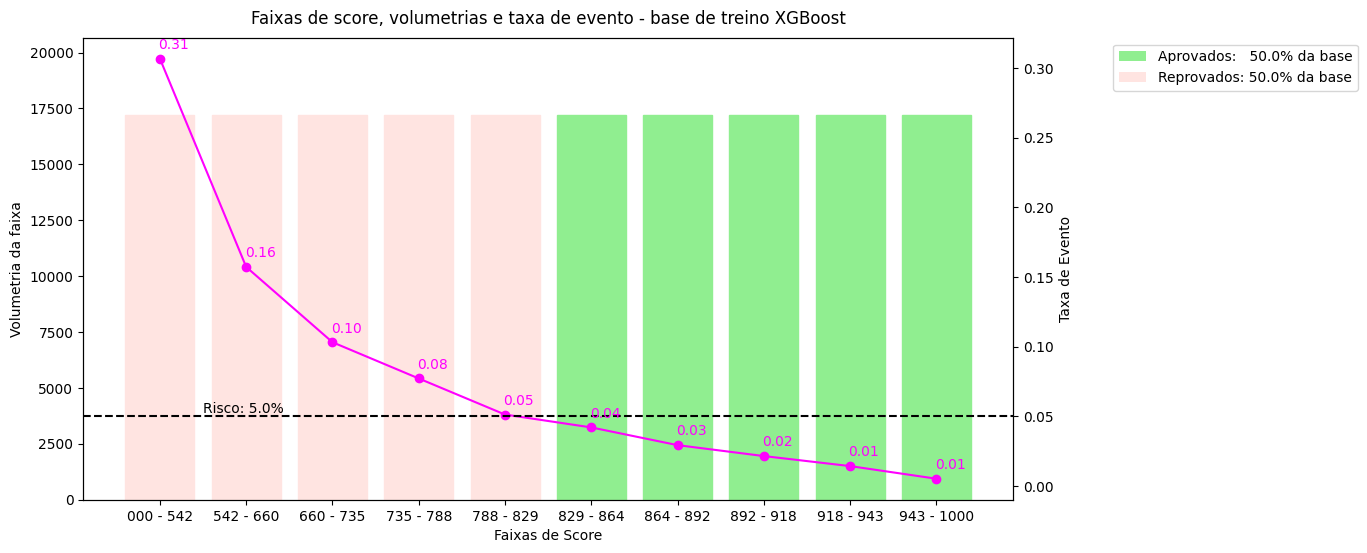

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 5,0%.
faixas_treino_5 = carteira_treino_rl(model, name_model, risk = 0.05, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

**Apetite de risco de 12,0% (ousado)**

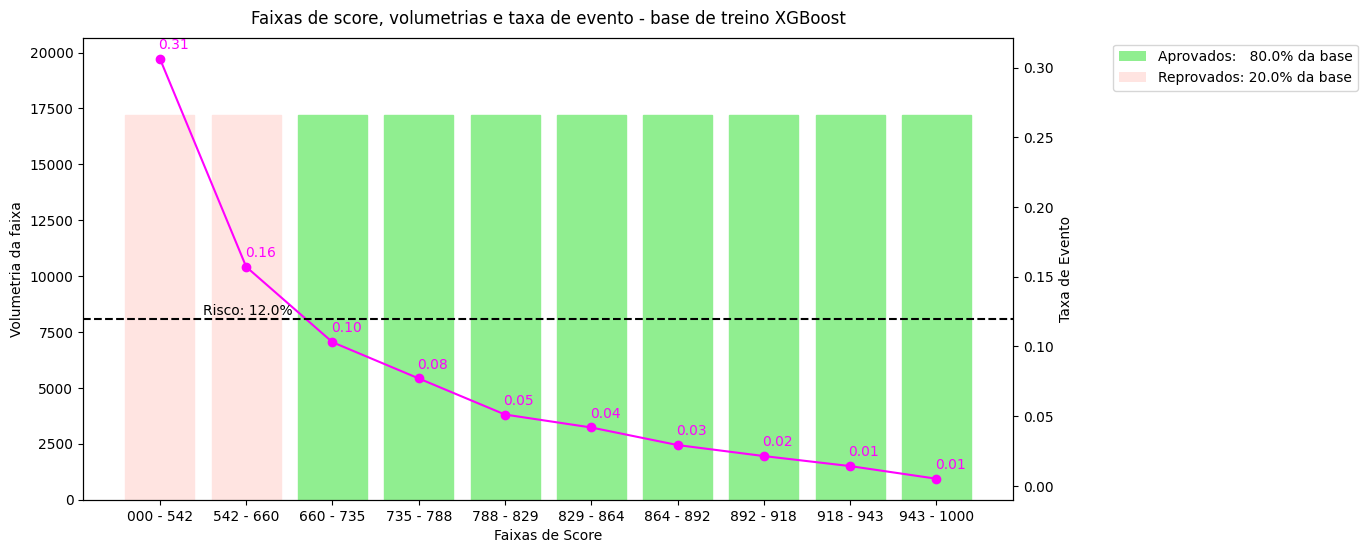

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 12,0%.
faixas_treino_12 = carteira_treino_rl(model, name_model, risk = 0.12, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

<br>

### **Teste**

**Apetite de risco de 8,0% (atual da carteira)**

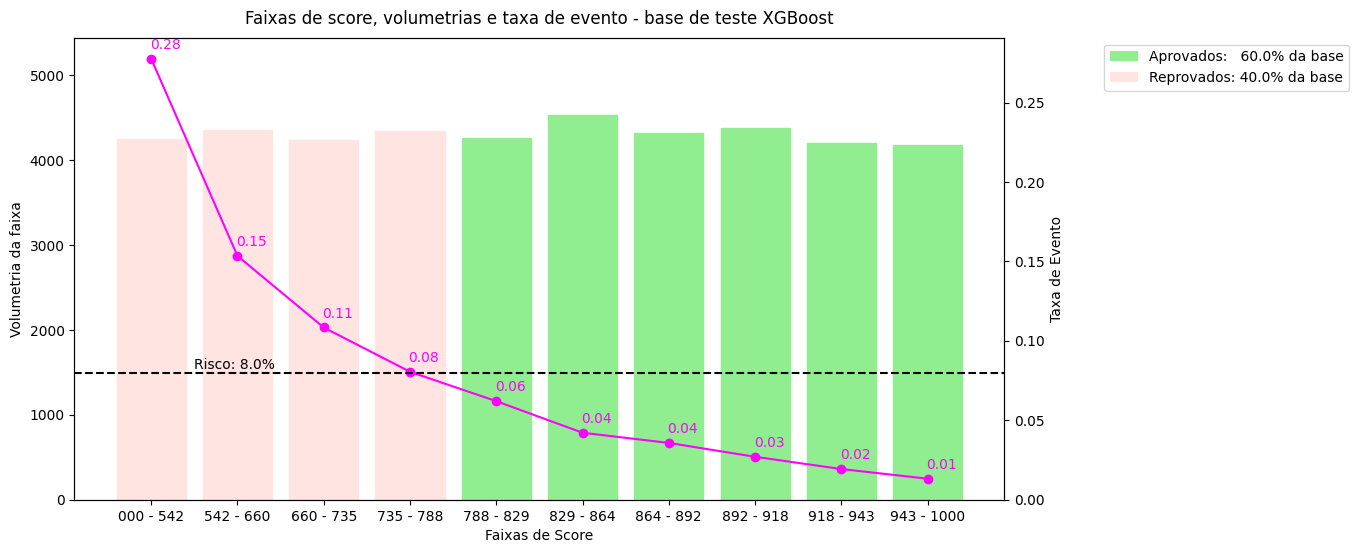

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_8 = carteira_teste_rl(faixas = faixas_treino_8, model = model, name_model = name_model, risk=0.08, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])

**Apetite de risco de 5,0% (conservador)**

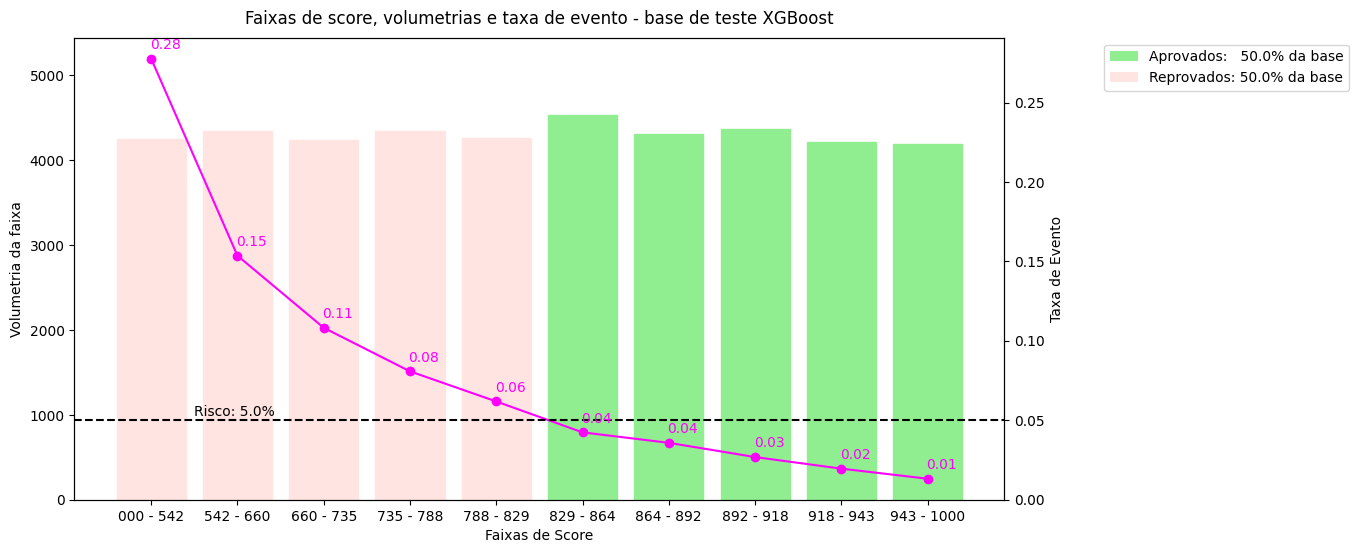

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_5 = carteira_teste_rl(faixas = faixas_treino_5, model = model, name_model = name_model, risk=0.05, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])

**Apetite de risco de 12,0% (ousado)**

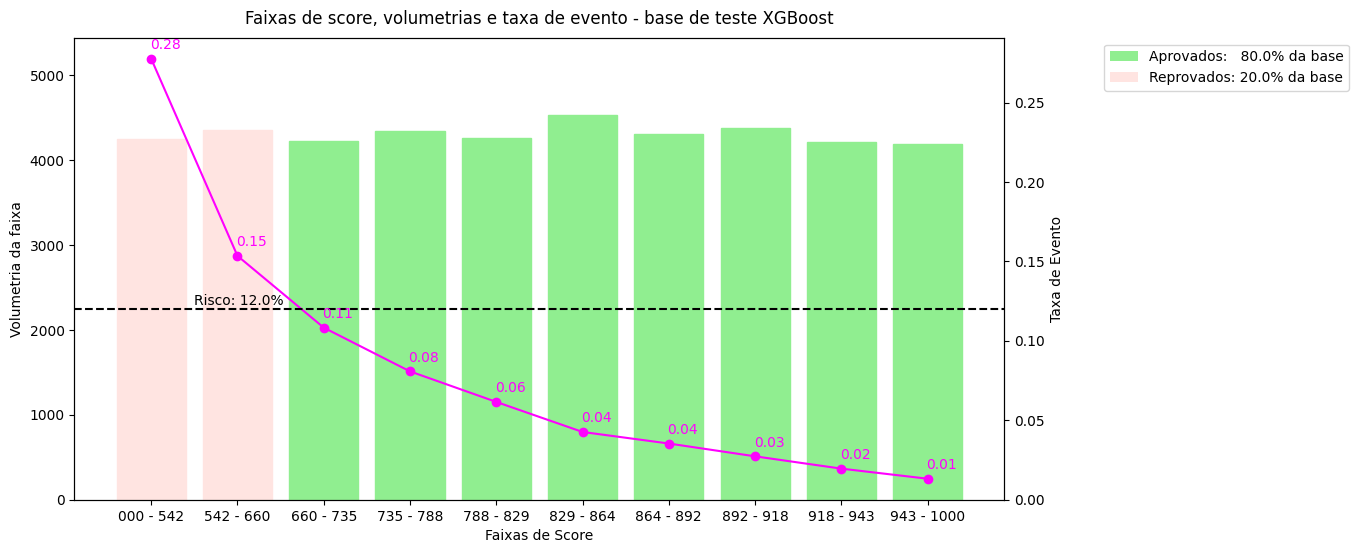

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 12,0%.
faixas_teste_12 = carteira_teste_rl(faixas = faixas_treino_12, model = model, name_model = name_model, risk=0.12, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])